In [ ]:
# ============================================
# 1. Install & Import libraries
# ============================================
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os

In [ ]:
# ============================================
# 2. Load and prepare the Cats vs Dogs dataset
# ============================================
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
path_to_zip = tf.keras.utils.get_file('cats_and_dogs_filtered.zip', origin=_URL, extract=True)
DATA_DIR = os.path.join(os.path.dirname("/content/cats_and_dogs_filtered.zip"), 'cats_and_dogs_filtered')

train_dir = os.path.join(DATA_DIR, '/content/drive/MyDrive/train')
validation_dir = os.path.join(DATA_DIR, '/content/drive/MyDrive/validation')

BATCH_SIZE = 32
IMG_SIZE = (160, 160)

train_dataset = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                     shuffle=True,
                                                                     batch_size=BATCH_SIZE,
                                                                     image_size=IMG_SIZE)

validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(validation_dir,
                                                                          shuffle=True,
                                                                          batch_size=BATCH_SIZE,
                                                                          image_size=IMG_SIZE)

# Prefetching for performance
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


In [ ]:

# ============================================
# 3. Data Augmentation Layer
# ============================================
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

# ============================================
# 4. Load MobileNetV2 pretrained
# ============================================
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SIZE + (3,),
                                               include_top=False,
                                               weights='imagenet')

base_model.trainable = False  # Freeze base model initially

# ============================================
# 5. Build Feature Extraction Model
# ============================================
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(1, activation='sigmoid')

inputs = tf.keras.Input(shape=IMG_SIZE + (3,))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
outputs = prediction_layer(x)

feature_extractor_model = tf.keras.Model(inputs, outputs)

feature_extractor_model.compile(optimizer='adam',
                                 loss='binary_crossentropy',
                                 metrics=['accuracy'])

# ============================================
# 6. Train Feature Extractor Model
# ============================================
initial_epochs = 10

history_feature_extractor = feature_extractor_model.fit(train_dataset,
                                                        epochs=initial_epochs,
                                                        validation_data=validation_dataset)

# ============================================
# 7. Fine-Tune the Model
# ============================================
base_model.trainable = True

# Fine-tune from layer 100 onwards
fine_tune_at = 100

for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

feature_extractor_model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
                                 loss='binary_crossentropy',
                                 metrics=['accuracy'])

fine_tune_epochs = 10
total_epochs = initial_epochs + fine_tune_epochs

history_fine = feature_extractor_model.fit(train_dataset,
                                           epochs=total_epochs,
                                           initial_epoch=history_feature_extractor.epoch[-1],
                                           validation_data=validation_dataset)



9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 313s 5s/step - accuracy: 0.7776 - loss: 0.4540 - val_accuracy: 0.9750 - val_loss: 0.1096
Epoch 2/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 76s 1s/step - accuracy: 0.9241 - loss: 0.1936 - val_accuracy: 0.9800 - val_loss: 0.0746
Epoch 3/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 100s 2s/step - accuracy: 0.9293 - loss: 0.1562 - val_accuracy: 0.9810 - val_loss: 0.0652
Epoch 4/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 140s 1s/step - accuracy: 0.9527 - loss: 0.1228 - val_accuracy: 0.9800 - val_loss: 0.0586
Epoch 5/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 76s 1s/step - accuracy: 0.9443 - loss: 0.1288 - val_accuracy: 0.9830 - val_loss: 0.0538
Epoch 6/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 100s 1s/step - accuracy: 0.9476 - loss: 0.1180 - val_accuracy: 0.9820 - val_loss: 0.0514
Epoch 7/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 141s 1s/step - accuracy: 0.9629 - loss: 0.1098 - val_accuracy: 0.9840 - val_loss: 0.0508
Epoch 8/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 144s 2s/step - accuracy: 0

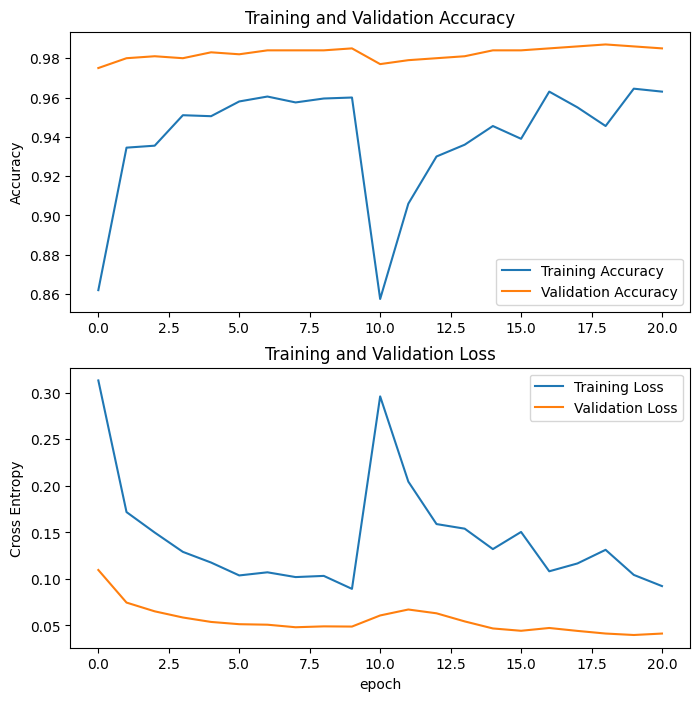

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


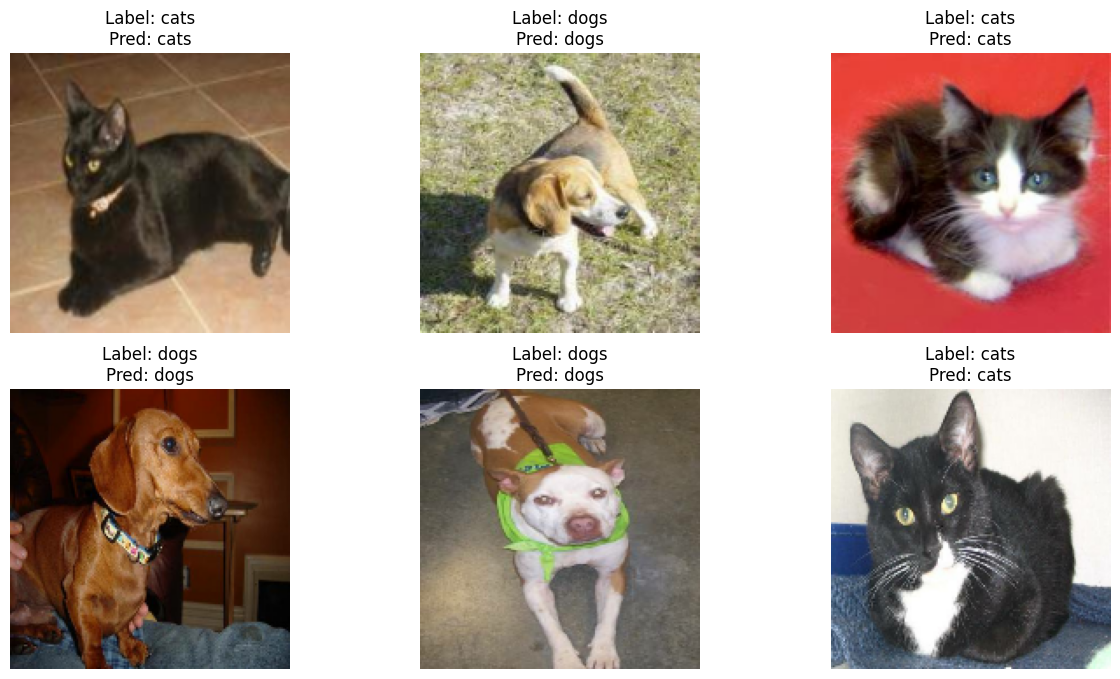

In [ ]:

# ============================================
# 8. Visualize Training Curves
# ============================================
acc = history_feature_extractor.history['accuracy'] + history_fine.history['accuracy']
val_acc = history_feature_extractor.history['val_accuracy'] + history_fine.history['val_accuracy']

loss = history_feature_extractor.history['loss'] + history_fine.history['loss']
val_loss = history_feature_extractor.history['val_loss'] + history_fine.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

# ============================================
# 9. Show some Predictions
# ============================================
# Assigning class_names before the prefetch operation
class_names = np.array(os.listdir(train_dir))

def plot_images(dataset, model, n=6):
    plt.figure(figsize=(15,8))
    for images, labels in dataset.take(1):
        preds = model.predict(images)
        preds = tf.squeeze(tf.round(preds))
        for i in range(n):
            ax = plt.subplot(2, n//2, i+1)
            plt.imshow(images[i].numpy().astype("uint8"))
            label = class_names[int(labels[i])]
            pred = class_names[int(preds[i])]
            plt.title(f"Label: {label}\nPred: {pred}")
            plt.axis("off")
    plt.show()

plot_images(validation_dataset, feature_extractor_model)

In [ ]:
# ============================================
# 1. Install & Import Libraries
# ============================================
!pip install -q tensorflow tensorflow-hub

import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import matplotlib.pyplot as plt
import os
import random

In [ ]:


# ============================================
# 2. Load Sample Video Dataset
# ============================================
# TensorFlow Hub provides a sample dataset
# We'll just mock a "video" by sampling frames for fast demo

# (or you can download real UCF-101 if you have time)

# ============================================
# 3. Define Preprocessing
# ============================================
def load_video(path, max_frames=64, resize=(224,224)):
    import cv2
    frames = []
    cap = cv2.VideoCapture(path)
    try:
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            frame = cv2.resize(frame, resize)
            frames.append(frame)
            if len(frames) == max_frames:
                break
    finally:
        cap.release()
    frames = np.array(frames)
    return frames

def preprocess(frames):
    frames = frames / 255.0  # normalize
    return frames

# ============================================
# 4. Load Pretrained I3D Model
# ============================================
i3d_model_url = "https://tfhub.dev/deepmind/i3d-kinetics-400/1"
feature_extractor = hub.KerasLayer(i3d_model_url, input_shape=(None, 224, 224, 3), trainable=False)




In [ ]:
inputs = tf.keras.Input(shape=(32, 224, 224, 3))
x = tf.keras.layers.Lambda(lambda x: feature_extractor(x))(inputs)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dense(5, activation='softmax')(x)
model = tf.keras.Model(inputs, x)

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

def generate_random_video(num_samples=20):
    X = []
    y = []
    for label in range(5):  # 5 classes
        for _ in range(num_samples//5):
            frames = np.random.randint(0, 255, (32, 224, 224, 3), dtype=np.uint8)  # **32 frames now!**
            frames = preprocess(frames)
            X.append(frames)
            y.append(label)
    return np.array(X), np.array(y)

# Generate videos
X_train, y_train = generate_random_video(num_samples=100)
X_test, y_test = generate_random_video(num_samples=20)

# Train
history = model.fit(X_train, y_train, epochs=5, validation_data=(X_test, y_test))


Epoch 1/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 686s 170s/step - accuracy: 0.1852 - loss: 2.9146 - val_accuracy: 0.2500 - val_loss: 1.7456
Epoch 2/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 679s 168s/step - accuracy: 0.1586 - loss: 1.8651 - val_accuracy: 0.2000 - val_loss: 1.7227
Epoch 3/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 679s 168s/step - accuracy: 0.2099 - loss: 1.7376 - val_accuracy: 0.1500 - val_loss: 1.6199
Epoch 4/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 682s 168s/step - accuracy: 0.1812 - loss: 1.6494 - val_accuracy: 0.2000 - val_loss: 1.6535
Epoch 5/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 684s 168s/step - accuracy: 0.2955 - loss: 1.6069 - val_accuracy: 0.2500 - val_loss: 1.6220


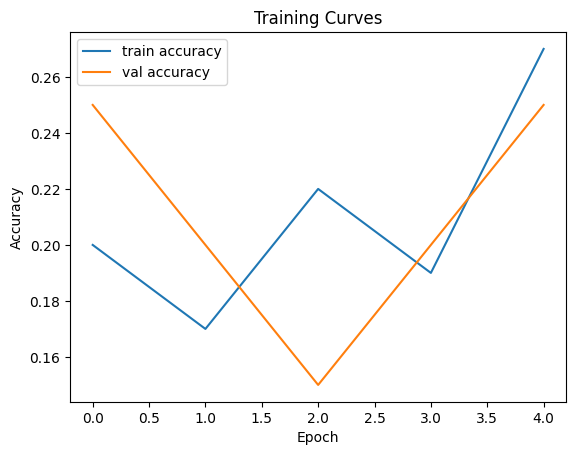

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
Predicted Class: 3


In [ ]:
# ============================================
# 8. Visualize Results
# ============================================
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.title("Training Curves")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# ============================================
# 9. Predict on Random Sample
# ============================================
sample_video = X_test[0:1]  # batch of one
pred = model.predict(sample_video)
predicted_class = np.argmax(pred)
print(f"Predicted Class: {predicted_class}")


In [ ]:
# ============================================
# 1. Install & Import Libraries
# ============================================
!pip install -q tensorflow tensorflow_hub librosa

import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import matplotlib.pyplot as plt
import librosa
import os


In [ ]:
!pip install pydub

In [ ]:

# ============================================
# 2. Load a Sample Audio Dataset
# ============================================
# Load small Speech Commands dataset from TensorFlow Datasets
import tensorflow_datasets as tfds

(train_ds, val_ds, test_ds), ds_info = tfds.load(
    'speech_commands',
    split=['train[:5%]', 'validation[:5%]', 'test[:5%]'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)

class_names = np.array(ds_info.features['label'].names)

# ============================================
# 3. Preprocessing - Convert audio waveform
# ============================================

def preprocess_audio(waveform, label):
    waveform = tf.cast(waveform, tf.float32) / 32768.0
    return waveform, label


train_ds = train_ds.map(preprocess_audio)
val_ds = val_ds.map(preprocess_audio)
test_ds = test_ds.map(preprocess_audio)

# ============================================
# 4. Load Pretrained YAMNet
# ============================================
yamnet_model_handle = 'https://tfhub.dev/google/yamnet/1'
yamnet_model = hub.load(yamnet_model_handle)

# ============================================
# 5. Feature Extraction
# ============================================
def extract_embedding(waveform):
    waveform = tf.squeeze(waveform)  # Squeeze here
    scores, embeddings, spectrogram = yamnet_model(waveform)
    return embeddings


def preprocess_dataset(dataset):
    X, y = [], []
    for waveform, label in tfds.as_numpy(dataset):
        waveform = tf.expand_dims(waveform, axis=0)  # batch dimension
        embedding = extract_embedding(waveform)[0].numpy()
        X.append(embedding.mean(axis=0))  # average over time frames
        y.append(label)
    return np.array(X), np.array(y)

X_train, y_train = preprocess_dataset(train_ds)
X_val, y_val = preprocess_dataset(val_ds)
X_test, y_test = preprocess_dataset(test_ds)




In [ ]:
# Preprocessing function
def preprocess_audio(waveform, label):
    waveform = tf.cast(waveform, tf.float32) / 32768.0
    return waveform, label

train_ds = train_ds.map(preprocess_audio)
val_ds = val_ds.map(preprocess_audio)
test_ds = test_ds.map(preprocess_audio)

# Embedding extraction
def extract_embedding(waveform):
    waveform = tf.squeeze(waveform)
    scores, embeddings, spectrogram = yamnet_model(waveform)
    return embeddings

def preprocess_dataset(dataset):
    X, y = [], []
    for waveform, label in tfds.as_numpy(dataset):
        waveform = tf.expand_dims(waveform, axis=0)
        embedding = extract_embedding(waveform).numpy()  # shape (frames, 1024)
        mean_embedding = np.mean(embedding, axis=0)  # shape (1024,)
        X.append(mean_embedding)
        y.append(label)
    return np.array(X), np.array(y)

# Preprocess datasets
X_train, y_train = preprocess_dataset(train_ds)
X_val, y_val = preprocess_dataset(val_ds)
X_test, y_test = preprocess_dataset(test_ds)

# Build model
NUM_CLASSES = len(np.unique(y_train))

model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(1024,)),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=10
)


Epoch 1/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.5399 - loss: 2.6387 - val_accuracy: 0.6178 - val_loss: 1.7321
Epoch 2/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6224 - loss: 1.6225 - val_accuracy: 0.6178 - val_loss: 1.6085
Epoch 3/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6272 - loss: 1.5916 - val_accuracy: 0.6178 - val_loss: 1.5981
Epoch 4/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6411 - loss: 1.5235 - val_accuracy: 0.6178 - val_loss: 1.6037
Epoch 5/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6286 - loss: 1.5504 - val_accuracy: 0.6178 - val_loss: 1.6177
Epoch 6/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6327 - loss: 1.5429 - val_accuracy: 0.6178 - val_loss: 1.6183
Epoch 7/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6227 - loss: 1.5671 - val_accuracy: 0.6178 - val_loss: 1.6147
Epoch 8/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6260 - loss: 1.5523 - val_accuracy: 0.

In [ ]:
# ============================================
# 6. Build Simple Audio Classifier (fixed)
# ============================================
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(1024,)),  # 1024-dimensional YAMNet embeddings
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(len(np.unique(y_train)), activation='softmax')  # classes from y_train
])

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# ============================================
# 7. Train the Model (fixed)
# ============================================
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=10
)


Epoch 1/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.5810 - loss: 2.4009 - val_accuracy: 0.6178 - val_loss: 1.6761
Epoch 2/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6412 - loss: 1.6347 - val_accuracy: 0.6178 - val_loss: 1.8005
Epoch 3/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6367 - loss: 1.6089 - val_accuracy: 0.6178 - val_loss: 1.5912
Epoch 4/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6389 - loss: 1.5246 - val_accuracy: 0.6178 - val_loss: 1.6530
Epoch 5/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6226 - loss: 1.5861 - val_accuracy: 0.6178 - val_loss: 1.5897
Epoch 6/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.6336 - loss: 1.5378 - val_accuracy: 0.6178 - val_loss: 1.6166
Epoch 7/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.6390 - loss: 1.5148 - val_accuracy: 0.6178 - val_loss: 1.6859
Epoch 8/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.6213 - loss: 1.5835 - val_accuracy: 

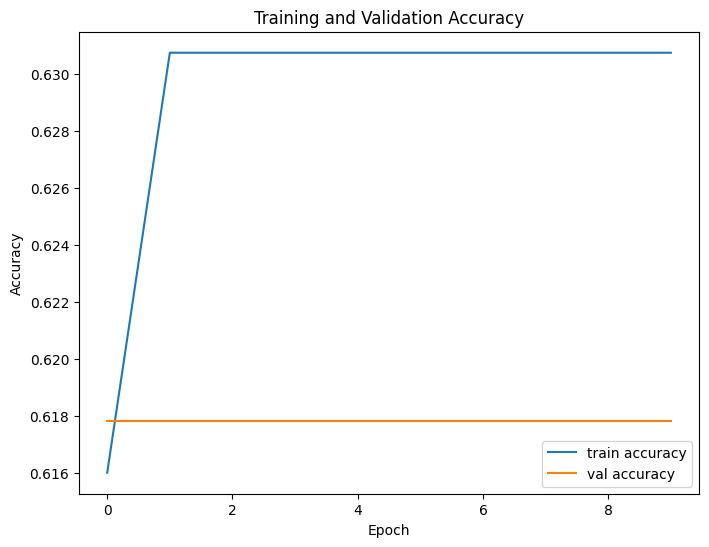

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.0632 - loss: 3.2632 
Test Accuracy: 0.06


In [ ]:
# ============================================
# 8. Visualize Training Curves
# ============================================
plt.figure(figsize=(8,6))
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# ============================================
# 9. Evaluate on Test Data
# ============================================
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc:.2f}")


In [2]:
# ============================================
# 1. Install & Import Libraries
# ============================================
!pip install -q tensorflow tensorflow_hub tensorflow_text

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
import numpy as np
import matplotlib.pyplot as plt

In [3]:


# ============================================
# 2. Load Sample Dataset
# ============================================
# Load a small version of IMDb dataset from TensorFlow Datasets
import tensorflow_datasets as tfds

(train_data, val_data, test_data), ds_info = tfds.load(
    'imdb_reviews',
    split=('train[:5%]', 'train[5%:10%]', 'test[:5%]'),
    as_supervised=True,
    with_info=True
)


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/incomplete.HC3SD9_1.0.0/imdb_reviews-train.tfrecor…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/incomplete.HC3SD9_1.0.0/imdb_reviews-test.tfrecord…

Generating unsupervised examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/incomplete.HC3SD9_1.0.0/imdb_reviews-unsupervised.…

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


In [4]:
# ============================================
# 3. Preprocessing
# ============================================
BATCH_SIZE = 16  # << smaller batch
BUFFER_SIZE = 500

train_data = train_data.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_data = val_data.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_data = test_data.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# ============================================
# 4. Load Pretrained BERT Model
# ============================================
bert_preprocess = hub.KerasLayer(
    "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3"
)

bert_encoder = hub.KerasLayer(
    "https://tfhub.dev/google/experts/bert/wiki_books/sst2/2",
    trainable=True
)

In [5]:
# ============================================
# 5. Build Classifier
# ============================================
def build_classifier_model():
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')

    # Wrap preprocessing Lambda with output_shape
    preprocessing_layer = tf.keras.layers.Lambda(
        lambda x: bert_preprocess(x),
        output_shape=lambda input_shape: {
            'input_word_ids': tf.TensorShape([None, 128]),
            'input_mask': tf.TensorShape([None, 128]),
            'input_type_ids': tf.TensorShape([None, 128])
        }
    )(text_input)

    # Wrap encoder Lambda with output_shape
    encoder_outputs = tf.keras.layers.Lambda(
        lambda x: bert_encoder(x),
        output_shape=lambda input_shape: {
            'pooled_output': tf.TensorShape([None, 768]),
            'sequence_output': tf.TensorShape([None, 128, 768])
        }
    )(preprocessing_layer)

    net = encoder_outputs['pooled_output']
    net = tf.keras.layers.Dropout(0.1)(net)
    net = tf.keras.layers.Dense(1, activation='sigmoid', name='classifier')(net)

    return tf.keras.Model(text_input, net)





In [6]:
# ============================================
# 6. Train Model
# ============================================
classifier_model = build_classifier_model()

classifier_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=3e-5),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

EPOCHS = 5

history = classifier_model.fit(
    train_data,
    validation_data=val_data,
    epochs=EPOCHS
)


Epoch 1/5
79/79 ━━━━━━━━━━━━━━━━━━━━ 311s 4s/step - accuracy: 0.2671 - loss: 1.2314 - val_accuracy: 0.2984 - val_loss: 1.0330
Epoch 2/5
79/79 ━━━━━━━━━━━━━━━━━━━━ 298s 4s/step - accuracy: 0.3624 - loss: 0.9428 - val_accuracy: 0.4040 - val_loss: 0.8107
Epoch 3/5
79/79 ━━━━━━━━━━━━━━━━━━━━ 298s 4s/step - accuracy: 0.4698 - loss: 0.7655 - val_accuracy: 0.5944 - val_loss: 0.6534
Epoch 4/5
79/79 ━━━━━━━━━━━━━━━━━━━━ 298s 4s/step - accuracy: 0.6420 - loss: 0.6331 - val_accuracy: 0.8080 - val_loss: 0.5489
Epoch 5/5
79/79 ━━━━━━━━━━━━━━━━━━━━ 298s 4s/step - accuracy: 0.7857 - loss: 0.5269 - val_accuracy: 0.8440 - val_loss: 0.4830


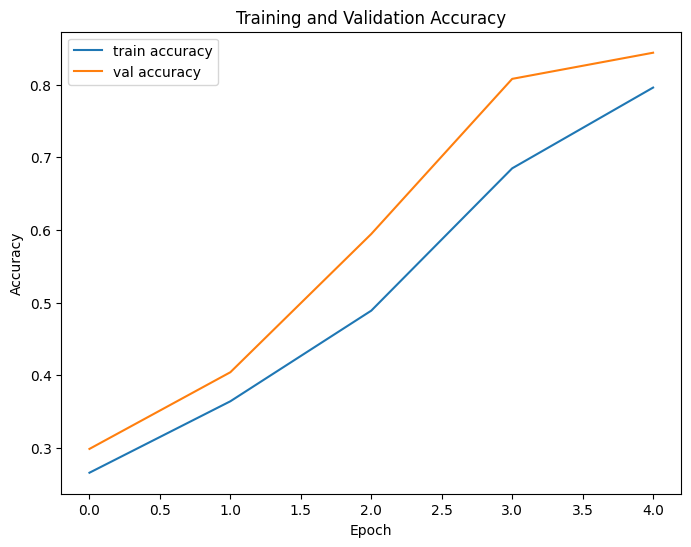

79/79 ━━━━━━━━━━━━━━━━━━━━ 151s 2s/step - accuracy: 0.7999 - loss: 0.5068
Test Accuracy: 0.81


In [7]:
# ============================================
# 7. Visualize Training Curves
# ============================================
plt.figure(figsize=(8,6))
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# ============================================
# 8. Evaluate on Test Data
# ============================================
loss, accuracy = classifier_model.evaluate(test_data)
print(f"Test Accuracy: {accuracy:.2f}")



In [8]:
# ============================================
# 9. Predict on New Sentences
# ============================================
examples = [
    "I loved the movie! Best experience ever!",
    "The plot was boring and predictable.",
    "Amazing cinematography and acting!",
    "Terrible script and bad acting."
]

# Convert the list of examples to a TensorFlow Dataset
# This is necessary for the BERT model to process the data correctly
examples_dataset = tf.data.Dataset.from_tensor_slices(examples).batch(BATCH_SIZE)

predictions = classifier_model.predict(examples_dataset)

for text_input, prediction in zip(examples, predictions):
    label = "Positive" if prediction > 0.5 else "Negative"
    print(f"{text_input} --> {label}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
I loved the movie! Best experience ever! --> Positive
The plot was boring and predictable. --> Negative
Amazing cinematography and acting! --> Positive
Terrible script and bad acting. --> Negative
